# FedAsync: Complete Self-Contained Notebook

This notebook contains all code needed to run FedAsync experiments:
- Library installation
- Data downloading and loading
- All FedAsync implementation
- Logging and checkpointing

**Run cells sequentially from top to bottom.**

## Google Colab Setup
This notebook is configured to save all results (logs, checkpoints, models) to Google Drive.
Data will be downloaded locally for faster access.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Google Colab Setup (Mount Drive)

**Skip this section if running locally.**


In [2]:
import os

# Google Colab: Mount Google Drive
try:
    from google.colab import drive
    IN_COLAB = True
    # Mount Google Drive
    drive.mount('/content/drive')
    # Define the target directory for saving results
    OUTPUT_DIR = "/content/drive/MyDrive/colab/dml_project"
    # Create the directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"✅ Google Drive mounted")
    print(f"✅ Output directory set to: {OUTPUT_DIR}")
    print(f"📁 All logs, checkpoints, and results will be saved to Google Drive")
except ImportError:
    IN_COLAB = False
    OUTPUT_DIR = None
    print("⚠️  Not running in Google Colab - using local paths")

# Install required packages
%pip install torch torchvision pytorch-lightning pyyaml numpy matplotlib pandas -q


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
✅ Output directory set to: /content/drive/MyDrive/colab/dml_project
📁 All logs, checkpoints, and results will be saved to Google Drive


## 2. Import Libraries and Setup


In [3]:
# Silence libraries
import os
import logging, warnings
os.environ["TQDM_DISABLE"] = "1"
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["LIGHTNING_DISABLE_RICH"] = "1"
for name in [
    "pytorch_lightning", "lightning", "lightning.pytorch",
    "lightning_fabric", "lightning_utilities", "torch", "torchvision",
]:
    logging.getLogger(name).setLevel(logging.ERROR)
    logging.getLogger(name).propagate = False
logging.getLogger().setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

# Core imports
import time
import csv
import threading
import random
import numpy as np
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any
from datetime import datetime
import subprocess
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

import pytorch_lightning as pl
import yaml
import pandas as pd
import matplotlib.pyplot as plt

# Setup paths based on environment
if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
    # Google Colab: Save everything to Drive except data
    BASE_OUTPUT_DIR = Path(OUTPUT_DIR)
    DATA_DIR = Path("./data")  # Local for faster access
    print(f"✅ Google Colab mode: Results → {BASE_OUTPUT_DIR}")
    print(f"✅ Data directory: {DATA_DIR} (local)")
else:
    # Local execution: Use current directory
    BASE_OUTPUT_DIR = Path(".")
    DATA_DIR = Path("./data")
    print(f"✅ Local mode: Results → {BASE_OUTPUT_DIR}")

print("✅ Libraries imported")


✅ Google Colab mode: Results → /content/drive/MyDrive/colab/dml_project
✅ Data directory: data (local)
✅ Libraries imported


## 3. Utility Functions


In [4]:
# ========== Helper Functions ==========

def set_seed(seed: int = 42) -> None:
    """Seed all RNGs for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device() -> torch.device:
    """Return the first available computation device (CUDA/MPS/CPU)."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def _device_to_accelerator(device: torch.device) -> str:
    """Convert torch device to PyTorch Lightning accelerator string."""
    if device.type == "cuda":
        return "gpu"
    if device.type == "mps":
        return "mps"
    return "cpu"

print("✅ Helper functions defined")


✅ Helper functions defined


In [5]:
# ========== Model Utilities ==========

def build_resnet18(num_classes: int = 10, pretrained: bool = False) -> nn.Module:
    """Create ResNet-18 adapted for CIFAR-10."""
    if pretrained:
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        m = models.resnet18(weights=None)
    # CIFAR-10: 32x32 -> use 3x3 conv, stride 1, no maxpool
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    # Replace classifier
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    m.num_classes = num_classes
    return m


def state_to_list(state: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
    """Flatten a state_dict to a list of tensors on CPU."""
    return [t.detach().cpu().clone() for _, t in state.items()]


def list_to_state(template: Dict[str, torch.Tensor], arrs: List[torch.Tensor]) -> Dict[str, torch.Tensor]:
    """Rebuild a state_dict from a list of tensors using a template."""
    out: Dict[str, torch.Tensor] = {}
    for (k, v), a in zip(template.items(), arrs):
        out[k] = a.to(v.device).type_as(v)
    return out

print("✅ Model utilities defined")


✅ Model utilities defined


In [6]:
# ========== Data Loading and Partitioning ==========

class DataDistributor:
    """Data distributor for federated learning with Dirichlet partitioning."""

    def __init__(self, dataset_name: str, data_dir: str = "./data"):
        self.dataset_name = dataset_name.lower()
        self.data_dir = data_dir
        self.train_dataset, self.test_dataset, self.num_classes = self._load_dataset()
        self.partitions = None

    def _load_dataset(self) -> Tuple[Any, Any, int]:
        """Load CIFAR-10 dataset with augmentation."""
        if self.dataset_name == "cifar10":
            # Strong data pipeline: augmentation for train, normalization for test
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.4914, 0.4822, 0.4465),
                    std=(0.2470, 0.2435, 0.2616),
                ),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.4914, 0.4822, 0.4465),
                    std=(0.2470, 0.2435, 0.2616),
                ),
            ])
            train = datasets.CIFAR10(self.data_dir, train=True, download=True, transform=transform_train)
            test = datasets.CIFAR10(self.data_dir, train=False, download=True, transform=transform_test)
            num_classes = 10
        else:
            raise ValueError(f"Dataset '{self.dataset_name}' not supported. Use 'cifar10'.")
        return train, test, num_classes

    def distribute_data(self, num_clients: int, alpha: float = 0.5, seed: int = 42):
        """Partition data using Dirichlet distribution."""
        np.random.seed(seed)
        targets = np.array(self.train_dataset.targets)
        self.partitions = {i: [] for i in range(num_clients)}

        for cls in range(self.num_classes):
            idxs = np.where(targets == cls)[0]
            np.random.shuffle(idxs)
            proportions = np.random.dirichlet(alpha=np.repeat(alpha, num_clients))
            proportions = np.array([p * len(idxs) for p in proportions]).astype(int)

            start = 0
            for client_id, size in enumerate(proportions):
                self.partitions[client_id].extend(idxs[start:start + size])
                start += size

        for cid in self.partitions:
            np.random.shuffle(self.partitions[cid])

    def get_client_data(self, client_id: int) -> Subset:
        """Get data subset for a specific client."""
        if self.partitions is None:
            raise ValueError("Data not distributed yet. Call distribute_data() first.")
        indices = self.partitions[client_id]
        return Subset(self.train_dataset, indices)

print("✅ DataDistributor class defined")


✅ DataDistributor class defined


## 4. FedAsync Client Implementation


In [7]:
# ========== FedAsync Client ==========

def _testloader(root: str, batch_size: int = 256):
    """Create test dataloader."""
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    ds = datasets.CIFAR10(root=root, train=False, download=True, transform=tfm)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)


def _evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float]:
    """Evaluate model on test set."""
    crit = nn.CrossEntropyLoss()
    model = model.to(device)
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = crit(logits, y)
            loss_sum += float(loss.item()) * y.size(0)
            total += y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
    return loss_sum / max(1, total), correct / max(1, total)


class LitCifar(pl.LightningModule):
    """PyTorch Lightning module for CIFAR-10 training."""

    def __init__(self, base_model: nn.Module, lr: float = 1e-3, momentum: float = 0.9, weight_decay: float = 5e-4):
        super().__init__()
        self.save_hyperparameters(ignore=["base_model"])
        self.model = base_model
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        # Store optimizer params directly
        self._optimizer_lr = lr
        self._optimizer_momentum = momentum
        self._optimizer_weight_decay = weight_decay
        self._train_loss_sum = 0.0
        self._train_correct = 0
        self._train_total = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        pred = logits.argmax(1)
        self._train_loss_sum += float(loss.item()) * y.size(0)
        self._train_correct += (pred == y).sum().item()
        self._train_total += y.size(0)
        return loss

    def on_train_epoch_start(self):
        self._train_loss_sum = 0.0
        self._train_correct = 0
        self._train_total = 0

    def get_epoch_metrics(self) -> Tuple[float, float]:
        if self._train_total == 0:
            return 0.0, 0.0
        return self._train_loss_sum / self._train_total, self._train_correct / self._train_total

    def configure_optimizers(self):
        return torch.optim.SGD(
            self.parameters(),
            lr=self._optimizer_lr,
            momentum=self._optimizer_momentum,
            weight_decay=self._optimizer_weight_decay
        )


class LocalAsyncClient:
    """FedAsync client that trains locally and submits updates immediately to server."""

    def __init__(
        self,
        cid: int,
        cfg: dict,
        subset: Subset,
        work_dir: str = "./checkpoints/clients",
        base_delay: float = 0.0,
        slow: bool = False,
        delay_ranges: Optional[tuple] = None,
        jitter: float = 0.0,
        fix_delay: bool = True,
    ):
        self.cid = cid
        self.cfg = cfg
        self.device = get_device()

        base = build_resnet18(num_classes=cfg["data"]["num_classes"], pretrained=False)
        lr = float(cfg["clients"]["lr"])
        momentum = float(cfg["clients"].get("momentum", 0.9))
        weight_decay = float(cfg["clients"].get("weight_decay", 5e-4))
        self.lit = LitCifar(base, lr=lr, momentum=momentum, weight_decay=weight_decay)

        self.loader = DataLoader(subset, batch_size=int(cfg["clients"]["batch_size"]),
                                 shuffle=True, num_workers=0)

        self.base_delay = float(base_delay)
        self.slow = bool(slow)
        self.delay_ranges = delay_ranges
        self.jitter = float(jitter)
        self.fix_delay = bool(fix_delay)

        if self.fix_delay and self.delay_ranges is not None:
            (a_s, b_s), (a_f, b_f) = self.delay_ranges
            if self.slow:
                self.base_delay = random.uniform(float(a_s), float(b_s))
            else:
                self.base_delay = random.uniform(float(a_f), float(b_f))

        self.accelerator = _device_to_accelerator(self.device)
        self.testloader = _testloader(cfg["data"]["data_dir"])

    def _to_list(self) -> List[torch.Tensor]:
        return state_to_list(self.lit.model.state_dict())

    def _from_list(self, arrs: List[torch.Tensor]) -> None:
        sd = self.lit.model.state_dict()
        new_sd = list_to_state(sd, arrs)
        self.lit.model.load_state_dict(new_sd, strict=True)
        self.lit.to(self.device)

    def _sleep_delay(self):
        global_d = float(self.cfg.get("server_runtime", {}).get("client_delay", 0.0))
        base = self.base_delay

        if not self.fix_delay and self.delay_ranges is not None:
            (a_s, b_s), (a_f, b_f) = self.delay_ranges
            if self.slow:
                base = random.uniform(float(a_s), float(b_s))
            else:
                base = random.uniform(float(a_f), float(b_f))

        jit = random.uniform(-self.jitter, self.jitter) if self.jitter > 0.0 else 0.0
        delay = max(0.0, global_d + base + jit)
        if delay > 0.0:
            time.sleep(delay)

    def fit_once(self, server) -> bool:
        params, version = server.get_global()
        self._from_list(params)

        self._sleep_delay()

        epochs = int(self.cfg["clients"]["local_epochs"])
        grad_clip = float(self.cfg["clients"].get("grad_clip", 1.0))
        trainer = pl.Trainer(
            max_epochs=epochs,
            accelerator=self.accelerator,
            devices=1,
            enable_checkpointing=False,
            logger=False,
            enable_model_summary=False,
            num_sanity_val_steps=0,
            enable_progress_bar=False,
            callbacks=[],
            gradient_clip_val=grad_clip,
            gradient_clip_algorithm="norm",
        )
        start = time.time()
        trainer.fit(self.lit, train_dataloaders=self.loader)
        duration = time.time() - start

        train_loss, train_acc = self.lit.get_epoch_metrics()
        test_loss, test_acc = _evaluate(self.lit.model, self.testloader, self.device)

        new_params = self._to_list()
        num_examples = len(self.loader.dataset)

        server.submit_update(
            client_id=self.cid,
            base_version=version,
            new_params=new_params,
            num_samples=num_examples,
            train_time_s=duration,
            train_loss=train_loss,
            train_acc=train_acc,
            test_loss=test_loss,
            test_acc=test_acc,
        )
        return not server.should_stop()

print("✅ FedAsync client classes defined")


✅ FedAsync client classes defined


In [8]:
# ========== FedAsync Server ==========

def _testloader_server(root: str, batch_size: int = 256):
    """Create test dataloader for server evaluation."""
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    ds = datasets.CIFAR10(root=root, train=False, download=True, transform=tfm)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)


def _evaluate_server(model: torch.nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float]:
    """Evaluate model on test set."""
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += float(loss.item()) * y.size(0)
            total += y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
    return loss_sum / max(1, total), correct / max(1, total)


class AsyncFedServer:
    """FedAsync server with staleness-aware aggregation (immediate updates, no buffering)."""

    def __init__(
        self,
        global_model: torch.nn.Module,
        total_train_samples: int,
        c: float = 0.5,
        mixing_alpha: float = 1.0,
        use_sample_weighing: bool = True,
        target_accuracy: float = 0.70,
        max_rounds: Optional[int] = None,
        eval_interval_s: int = 15,
        data_dir: str = "./data",
        checkpoints_dir: str = "./checkpoints/FedAsync",
        logs_dir: str = "./logs/FedAsync",
        global_log_csv: Optional[str] = None,
        client_participation_csv: Optional[str] = None,
        final_model_path: Optional[str] = None,
        resume: bool = True,
        device: Optional[torch.device] = None,
    ):
        self.model = global_model
        self.template = {k: v.detach().clone() for k, v in self.model.state_dict().items()}
        self.device = device or get_device()
        self.model.to(self.device)

        self.total_train_samples = int(total_train_samples)
        self.c = float(c)
        self.mixing_alpha = float(mixing_alpha)
        self.use_sample_weighing = bool(use_sample_weighing)

        self.eval_interval_s = int(eval_interval_s)
        self.target_accuracy = float(target_accuracy)
        self.max_rounds = int(max_rounds) if max_rounds is not None else None

        self.data_dir = data_dir
        self.ckpt_dir = Path(checkpoints_dir)
        self.ckpt_dir.mkdir(parents=True, exist_ok=True)
        self.log_dir = Path(logs_dir)
        self.log_dir.mkdir(parents=True, exist_ok=True)

        self.csv_path = Path(global_log_csv) if global_log_csv else (self.log_dir / "FedAsync.csv")
        self.participation_csv = Path(client_participation_csv) if client_participation_csv else (self.log_dir / "FedAsyncClientParticipation.csv")
        self.final_model_path = Path(final_model_path) if final_model_path else Path("./results/FedAsyncModel.pt")
        self.final_model_path.parent.mkdir(parents=True, exist_ok=True)

        if not self.csv_path.exists():
            self.csv_path.parent.mkdir(parents=True, exist_ok=True)
            with self.csv_path.open("w", newline="") as f:
                csv.writer(f).writerow(["total_agg", "avg_train_loss", "avg_train_acc",
                                        "test_loss", "test_acc", "time"])

        if not self.participation_csv.exists():
            self.participation_csv.parent.mkdir(parents=True, exist_ok=True)
            with self.participation_csv.open("w", newline="") as f:
                csv.writer(f).writerow([
                    "client_id", "local_train_loss", "local_train_acc",
                    "local_test_loss", "local_test_acc", "total_agg"
                ])

        self._lock = threading.Lock()
        self._stop = False
        self.t_round = 0
        self._log_count = 0
        self.testloader = _testloader_server(self.data_dir)
        self._train_loss_acc_accum: List[Tuple[float, float, int]] = []
        self._start_ts = time.time()

        if resume:
            self._maybe_resume()

    def _ckpt_file(self) -> Path:
        return self.ckpt_dir / "server_last.ckpt"

    def _maybe_resume(self) -> None:
        ck = self._ckpt_file()
        if ck.exists():
            try:
                blob = torch.load(ck, map_location="cpu")
                state = list_to_state(self.template, blob["global_params"])
                self.model.load_state_dict(state, strict=True)
                self.t_round = int(blob["t_round"])
                print(f"[resume] Loaded server checkpoint at total_agg={self.t_round}")
            except (RuntimeError, KeyError) as e:
                print(f"[resume] Checkpoint incompatible, starting fresh: {type(e).__name__}")
                ck.unlink()
                self.t_round = 0

    def _save_ckpt(self) -> None:
        sd = state_to_list(self.model.state_dict())
        torch.save({"t_round": self.t_round, "global_params": sd}, self._ckpt_file())

    def _save_final_model(self) -> None:
        torch.save(self.model.state_dict(), self.final_model_path)

    def get_global(self):
        with self._lock:
            return state_to_list(self.model.state_dict()), self.t_round

    def submit_update(
        self,
        client_id: int,
        base_version: int,
        new_params: List[torch.Tensor],
        num_samples: int,
        train_time_s: float,
        train_loss: float,
        train_acc: float,
        test_loss: float,
        test_acc: float,
    ) -> None:
        with self._lock:
            if self._stop:
                return
            if self.max_rounds is not None and self.t_round >= self.max_rounds:
                self._stop = True
                return

            # Log client participation
            with self.participation_csv.open("a", newline="") as f:
                csv.writer(f).writerow([
                    client_id, f"{train_loss:.6f}", f"{train_acc:.6f}",
                    f"{test_loss:.6f}", f"{test_acc:.6f}", self.t_round
                ])

            # FedAsync staleness-aware aggregation
            staleness = max(0, self.t_round - base_version)
            alpha = self.c / float(staleness + 1)  # Staleness weight: c/(staleness+1)
            sw = float(num_samples) / float(self.total_train_samples) if self.use_sample_weighing else 1.0
            eff = alpha * self.mixing_alpha * sw  # Effective update rate

            # Immediate merge (no buffering)
            g = state_to_list(self.model.state_dict())
            merged = [(1.0 - eff) * gi + eff * ci for gi, ci in zip(g, new_params)]
            new_state = list_to_state(self.template, merged)
            self.model.load_state_dict(new_state, strict=True)

            # Accumulate metrics
            self._train_loss_acc_accum.append((float(train_loss), float(train_acc), int(num_samples)))

            self.t_round += 1
            self._save_ckpt()

    def should_stop(self) -> bool:
        with self._lock:
            return self._stop

    def mark_stop(self) -> None:
        with self._lock:
            self._stop = True
            self._save_final_model()
            print(f"[LOG] saved final model -> {self.final_model_path}")

    def _compute_avg_train(self) -> Tuple[float, float]:
        if not self._train_loss_acc_accum:
            return 0.0, 0.0
        loss_sum, acc_sum, n_sum = 0.0, 0.0, 0
        for l, a, n in self._train_loss_acc_accum:
            loss_sum += l * n
            acc_sum += a * n
            n_sum += n
        return loss_sum / max(1, n_sum), acc_sum / max(1, n_sum)

    def _periodic_eval_and_log(self):
        test_loss, test_acc = _evaluate_server(self.model, self.testloader, self.device)
        avg_train_loss, avg_train_acc = self._compute_avg_train()
        now = time.time() - self._start_ts
        self._train_loss_acc_accum.clear()

        with self.csv_path.open("a", newline="") as f:
            csv.writer(f).writerow([
                self.t_round, f"{avg_train_loss:.6f}", f"{avg_train_acc:.6f}",
                f"{test_loss:.6f}", f"{test_acc:.6f}", f"{now:.3f}"
            ])
        print(f"[LOG] total_agg={self.t_round} "
              f"avg_train_loss={avg_train_loss:.4f} avg_train_acc={avg_train_acc:.4f} "
              f"test_loss={test_loss:.4f} test_acc={test_acc:.4f} time={now:.1f}s")

        self._log_count += 1
        if self._log_count % 100 == 0:
            path = self.ckpt_dir / f"global_log{self._log_count}_t{self.t_round}.pt"
            torch.save(self.model.state_dict(), path)

        if test_acc >= self.target_accuracy:
            self._stop = True

    def start_eval_timer(self):
        def _loop():
            next_ts = time.time() + self.eval_interval_s
            while True:
                now = time.time()
                sleep_for = max(0.0, next_ts - now)
                time.sleep(sleep_for)
                with self._lock:
                    if self._stop:
                        break
                    self._periodic_eval_and_log()
                next_ts += self.eval_interval_s
        threading.Thread(target=_loop, daemon=True).start()

    def wait(self):
        try:
            while not self.should_stop():
                time.sleep(0.2)
        finally:
            self.mark_stop()

print("✅ FedAsync server class defined")


✅ FedAsync server class defined


In [9]:
# ========== All 6 Experiment Configurations ==========

# Helper function to get paths (works for both Colab and local)
def get_paths(exp_id: str):
    """Get paths for experiment, using Google Drive if in Colab."""
    if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
        base = BASE_OUTPUT_DIR
    else:
        base = Path(".")

    return {
        "data_dir": str(DATA_DIR),  # Always local for faster access
        "checkpoints_dir": str(base / "checkpoints" / "FedAsync" / exp_id),
        "logs_dir": str(base / "logs" / "FedAsync" / exp_id),
        "results_dir": str(base / "results" / "FedAsync" / exp_id),
    }

experiments = {
    "Exp1": {
        "name": "IID (alpha=1000), no stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 0,
            "delay_slow_range": [0.0, 0.0],
            "delay_fast_range": [0.0, 0.0],
            "jitter_per_round": 0.0,
            "fix_delays_per_client": True
        },
        "async": {
            "c": 0.5,
            "fedasync_mixing_alpha": 1.0,
            "use_sample_weighing": True
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 1000.0,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp1")
    },
    "Exp2": {
        "name": "alpha=0.1, 10% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 10,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "async": {
            "c": 0.5,
            "fedasync_mixing_alpha": 1.0,
            "use_sample_weighing": True
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp2")
    },
    "Exp3": {
        "name": "alpha=0.1, 20% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 20,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "async": {
            "c": 0.5,
            "fedasync_mixing_alpha": 1.0,
            "use_sample_weighing": True
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp3")
    },
    "Exp4": {
        "name": "alpha=0.1, 30% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 30,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "async": {
            "c": 0.5,
            "fedasync_mixing_alpha": 1.0,
            "use_sample_weighing": True
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp4")
    },
    "Exp5": {
        "name": "alpha=0.1, 40% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 40,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "async": {
            "c": 0.5,
            "fedasync_mixing_alpha": 1.0,
            "use_sample_weighing": True
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp5")
    },
    "Exp6": {
        "name": "alpha=0.1, 50% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 50,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "async": {
            "c": 0.5,
            "fedasync_mixing_alpha": 1.0,
            "use_sample_weighing": True
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp6")
    }
}

print("✅ All 6 experiment configurations loaded:")
for exp_id, exp_config in experiments.items():
    print(f"  {exp_id}: {exp_config['name']}")
    print(f"    - Alpha: {exp_config['partition_alpha']}")
    print(f"    - Stragglers: {exp_config['clients']['struggle_percent']}%")
    print(f"    - Max rounds: {exp_config['train']['max_rounds']}")


✅ All 6 experiment configurations loaded:
  Exp1: IID (alpha=1000), no stragglers
    - Alpha: 1000.0
    - Stragglers: 0%
    - Max rounds: 500
  Exp2: alpha=0.1, 10% stragglers
    - Alpha: 0.1
    - Stragglers: 10%
    - Max rounds: 500
  Exp3: alpha=0.1, 20% stragglers
    - Alpha: 0.1
    - Stragglers: 20%
    - Max rounds: 500
  Exp4: alpha=0.1, 30% stragglers
    - Alpha: 0.1
    - Stragglers: 30%
    - Max rounds: 500
  Exp5: alpha=0.1, 40% stragglers
    - Alpha: 0.1
    - Stragglers: 40%
    - Max rounds: 500
  Exp6: alpha=0.1, 50% stragglers
    - Alpha: 0.1
    - Stragglers: 50%
    - Max rounds: 500


In [10]:
def run_single_experiment(exp_id: str, experiments_dict: dict):
    """
    Run a single FedAsync experiment.

    Args:
        exp_id: Experiment ID (e.g., "Exp1", "Exp2", ..., "Exp6")
        experiments_dict: Dictionary containing all experiment configs
    """
    if exp_id not in experiments_dict:
        print(f"❌ Error: Experiment {exp_id} not found!")
        return None

    config = experiments_dict[exp_id]
    print(f"\n{'='*70}")
    print(f"Running {exp_id}: {config['name']}")
    print(f"{'='*70}")

    # Set random seed
    seed = int(config.get("seed", 42))
    set_seed(seed)
    random.seed(seed)

    # Create timestamped run folder
    run_dir = Path(config["io"]["logs_dir"]) / f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_dir.mkdir(parents=True, exist_ok=True)

    # Write COMMIT.txt
    commit_hash = "notebook_run"
    csv_header = "total_agg,avg_train_loss,avg_train_acc,test_loss,test_acc,time"
    with (run_dir / "COMMIT.txt").open("w") as f:
        f.write(f"{commit_hash},{csv_header}\n")

    # Save config to run folder
    with (run_dir / "CONFIG.yaml").open("w") as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False)

    print(f"✅ Run folder: {run_dir}")

    # Load and partition data
    dd = DataDistributor(dataset_name=config["data"]["dataset"], data_dir=config["data"]["data_dir"])
    dd.distribute_data(
        num_clients=int(config["clients"]["total"]),
        alpha=float(config["partition_alpha"]),
        seed=seed
    )
    print(f"✅ Data partitioned: {config['clients']['total']} clients, alpha={config['partition_alpha']}")

    # Build global model
    global_model = build_resnet18(num_classes=config["data"]["num_classes"], pretrained=False)

    # Initialize server
    server = AsyncFedServer(
        global_model=global_model,
        total_train_samples=len(dd.train_dataset),
        c=float(config["async"]["c"]),
        mixing_alpha=float(config["async"]["fedasync_mixing_alpha"]),
        use_sample_weighing=bool(config["async"]["use_sample_weighing"]),
        target_accuracy=float(config["eval"]["target_accuracy"]),
        max_rounds=int(config["train"]["max_rounds"]) if "max_rounds" in config["train"] else None,
        eval_interval_s=int(config["eval"]["interval_seconds"]),
        data_dir=config["data"]["data_dir"],
        checkpoints_dir=str(run_dir / "checkpoints"),
        logs_dir=str(run_dir),
        global_log_csv=str(run_dir / "FedAsync.csv"),
        client_participation_csv=str(run_dir / "FedAsyncClientParticipation.csv"),
        final_model_path=str(run_dir / "FedAsyncModel.pt"),
        resume=False,
        device=get_device(),
    )
    print(f"✅ Server initialized (device: {server.device})")
    print(f"   c: {server.c}, mixing_alpha: {server.mixing_alpha}")

    # Setup clients
    n = int(config["clients"]["total"])
    pct = max(0, min(100, int(config["clients"].get("struggle_percent", 0))))
    k_slow = (n * pct) // 100
    slow_ids = set(random.sample(range(n), k_slow)) if k_slow > 0 else set()

    a_s, b_s = config["clients"].get("delay_slow_range", [0.8, 2.0])
    a_f, b_f = config["clients"].get("delay_fast_range", [0.0, 0.2])
    fix_delays = bool(config["clients"].get("fix_delays_per_client", True))
    jitter = float(config["clients"].get("jitter_per_round", 0.0))

    per_client_base_delay: Dict[int, float] = {}
    if fix_delays:
        for cid in range(n):
            if cid in slow_ids:
                per_client_base_delay[cid] = random.uniform(float(a_s), float(b_s))
            else:
                per_client_base_delay[cid] = random.uniform(float(a_f), float(b_f))

    clients = []
    for cid in range(n):
        subset = dd.get_client_data(cid)
        base_delay = per_client_base_delay.get(cid, 0.0)
        is_slow = cid in slow_ids
        clients.append(LocalAsyncClient(
            cid=cid,
            cfg=config,
            subset=subset,
            work_dir=str(run_dir / "checkpoints" / "clients"),
            base_delay=base_delay,
            slow=is_slow,
            delay_ranges=((float(a_s), float(b_s)), (float(a_f), float(b_f))),
            jitter=jitter,
            fix_delay=fix_delays,
        ))

    print(f"✅ Created {len(clients)} clients ({len(slow_ids)} slow, {n - len(slow_ids)} fast)")

    # Start experiment
    server.start_eval_timer()
    sem = threading.Semaphore(int(config["clients"]["concurrent"]))

    def client_loop(client: LocalAsyncClient):
        while True:
            with sem:
                cont = client.fit_once(server)
            if not cont:
                break
            time.sleep(0.05)

    threads = []
    for cl in clients:
        t = threading.Thread(target=client_loop, args=(cl,), daemon=False)
        t.start()
        threads.append(t)

    print(f"✅ Started {len(threads)} client threads")
    print(f"🚀 Experiment running... (max {config['train']['max_rounds']} rounds)")

    # Wait for completion
    server.wait()
    for t in threads:
        t.join()

    print(f"\n✅ {exp_id} completed!")
    print(f"📁 Results: {run_dir}")

    return run_dir

print("✅ Helper function `run_single_experiment()` defined")
print("   Usage: run_dir = run_single_experiment('Exp1', experiments)")


✅ Helper function `run_single_experiment()` defined
   Usage: run_dir = run_single_experiment('Exp1', experiments)


## 8. Run All 6 Experiments Sequentially

This cell runs all experiments one by one. Each experiment saves to its own folder.


In [11]:
# Run all 6 experiments sequentially
experiment_results = {}

print("\n" + "="*70)
print("STARTING ALL 6 EXPERIMENTS")
print("="*70)

total_start = time.time()

for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
    exp_start = time.time()
    try:
        run_dir = run_single_experiment(exp_id, experiments)
        if run_dir:
            experiment_results[exp_id] = {
                "run_dir": run_dir,
                "status": "completed",
                "duration_min": (time.time() - exp_start) / 60.0
            }
            print(f"✅ {exp_id} completed in {experiment_results[exp_id]['duration_min']:.2f} minutes")
        else:
            experiment_results[exp_id] = {"status": "failed", "duration_min": (time.time() - exp_start) / 60.0}
    except Exception as e:
        print(f"❌ {exp_id} failed: {str(e)}")
        experiment_results[exp_id] = {"status": "error", "error": str(e), "duration_min": (time.time() - exp_start) / 60.0}

    print(f"\n{'─'*70}\n")

total_duration = (time.time() - total_start) / 60.0

print("="*70)
print("ALL EXPERIMENTS COMPLETED")
print("="*70)
print(f"Total time: {total_duration:.2f} minutes ({total_duration/60:.2f} hours)")
print("\nResults summary:")
for exp_id, result in experiment_results.items():
    if result.get("status") == "completed":
        print(f"  {exp_id}: ✅ {result['duration_min']:.2f} min -> {result['run_dir']}")
    else:
        print(f"  {exp_id}: ❌ {result.get('status', 'unknown')}")
print("="*70)



STARTING ALL 6 EXPERIMENTS

Running Exp1: IID (alpha=1000), no stragglers
✅ Run folder: /content/drive/MyDrive/colab/dml_project/logs/FedAsync/Exp1/run_20251130_055731
✅ Data partitioned: 20 clients, alpha=1000.0
✅ Server initialized (device: cuda)
   c: 0.5, mixing_alpha: 1.0
✅ Created 20 clients (0 slow, 20 fast)
✅ Started 20 client threads
🚀 Experiment running... (max 500 rounds)
[LOG] total_agg=0 avg_train_loss=0.0000 avg_train_acc=0.0000 test_loss=2.4518 test_acc=0.1214 time=47.4s
[LOG] total_agg=0 avg_train_loss=0.0000 avg_train_acc=0.0000 test_loss=2.4518 test_acc=0.1214 time=64.0s
[LOG] total_agg=5 avg_train_loss=2.3111 avg_train_acc=0.1212 test_loss=2.4017 test_acc=0.1199 time=67.8s
[LOG] total_agg=5 avg_train_loss=0.0000 avg_train_acc=0.0000 test_loss=2.4017 test_acc=0.1199 time=70.3s
[LOG] total_agg=5 avg_train_loss=0.0000 avg_train_acc=0.0000 test_loss=2.4017 test_acc=0.1199 time=103.0s
[LOG] total_agg=5 avg_train_loss=0.0000 avg_train_acc=0.0000 test_loss=2.4017 test_acc=

## 9. Compare All Experiments (After Running)

This section creates comparison plots across all 6 experiments.


✅ Loaded Exp1: 409 rows
✅ Loaded Exp2: 413 rows
✅ Loaded Exp3: 423 rows
✅ Loaded Exp4: 420 rows
✅ Loaded Exp5: 424 rows
✅ Loaded Exp6: 418 rows

✅ Comparison plot saved: /content/drive/MyDrive/colab/dml_project/logs/FedAsync/comparisons/all_experiments_comparison.png


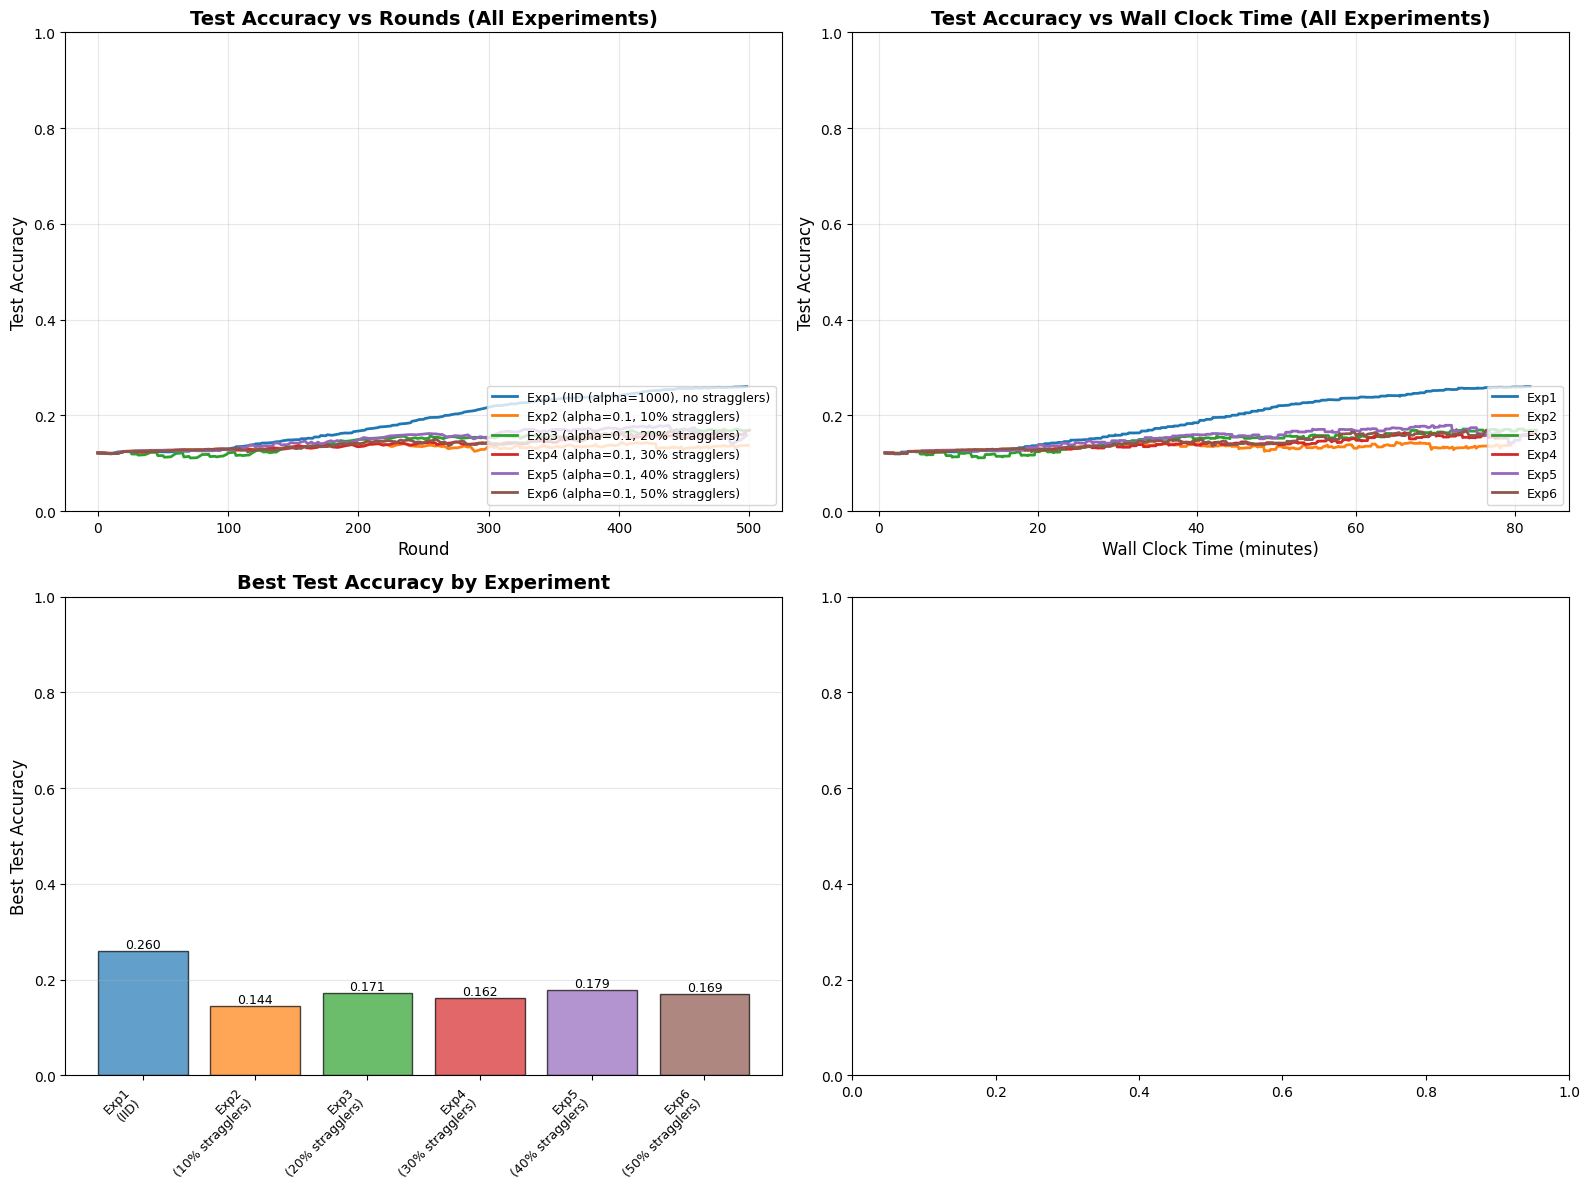


EXPERIMENT COMPARISON SUMMARY
Exp    Alpha    Stragglers   Best Acc   Final Acc   Time (min)  
--------------------------------------------------------------------------------
Exp1   1000.0   0            0.2599     0.2599      81.95       
Exp2   0.1      10           0.1438     0.1371      79.56       
Exp3   0.1      20           0.1713     0.1689      82.76       
Exp4   0.1      30           0.1620     0.1612      82.66       
Exp5   0.1      40           0.1791     0.1580      81.63       
Exp6   0.1      50           0.1689     0.1689      76.56       


In [12]:
# Compare all experiments (load results from experiment_results)
if 'experiment_results' in globals() and len(experiment_results) > 0:
    # Load all CSV files
    all_data = {}
    for exp_id, result in experiment_results.items():
        if result.get("status") == "completed":
            csv_path = result["run_dir"] / "FedAsync.csv"
            if csv_path.exists():
                df = pd.read_csv(csv_path)
                df['time_min'] = df['time'] / 60.0
                all_data[exp_id] = df
                print(f"✅ Loaded {exp_id}: {len(df)} rows")

    if len(all_data) > 0:
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

        # Plot 1: Accuracy vs Rounds
        for i, (exp_id, df) in enumerate(all_data.items()):
            axes[0, 0].plot(df['total_agg'], df['test_acc'],
                          label=f"{exp_id} ({experiments[exp_id]['name']})",
                          linewidth=2, color=colors[i % len(colors)])
        axes[0, 0].set_xlabel('Round', fontsize=12)
        axes[0, 0].set_ylabel('Test Accuracy', fontsize=12)
        axes[0, 0].set_title('Test Accuracy vs Rounds (All Experiments)', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=9, loc='lower right')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim([0, 1.0])

        # Plot 2: Accuracy vs Wall Clock Time
        for i, (exp_id, df) in enumerate(all_data.items()):
            axes[0, 1].plot(df['time_min'], df['test_acc'],
                          label=f"{exp_id}",
                          linewidth=2, color=colors[i % len(colors)])
        axes[0, 1].set_xlabel('Wall Clock Time (minutes)', fontsize=12)
        axes[0, 1].set_ylabel('Test Accuracy', fontsize=12)
        axes[0, 1].set_title('Test Accuracy vs Wall Clock Time (All Experiments)', fontsize=14, fontweight='bold')
        axes[0, 1].legend(fontsize=9, loc='lower right')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim([0, 1.0])

        # Plot 3: Best Accuracy by Experiment
        best_accs = {exp_id: df['test_acc'].max() for exp_id, df in all_data.items()}
        exp_names = [f"{exp_id}\n({experiments[exp_id]['clients']['struggle_percent']}% stragglers)"
                    if exp_id != 'Exp1' else f"{exp_id}\n(IID)"
                    for exp_id in best_accs.keys()]
        axes[1, 0].bar(range(len(best_accs)), list(best_accs.values()),
                      color=colors[:len(best_accs)], alpha=0.7, edgecolor='black')
        axes[1, 0].set_xticks(range(len(best_accs)))
        axes[1, 0].set_xticklabels(exp_names, fontsize=9, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Best Test Accuracy', fontsize=12)
        axes[1, 0].set_title('Best Test Accuracy by Experiment', fontsize=14, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        axes[1, 0].set_ylim([0, 1.0])
        # Add value labels
        for i, (exp_id, acc) in enumerate(best_accs.items()):
            axes[1, 0].text(i, acc, f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

        # Plot 4: Time to reach 50% accuracy
        times_to_50 = {}
        for exp_id, df in all_data.items():
            mask = df['test_acc'] >= 0.5
            if mask.any():
                first_idx = mask.idxmax()
                times_to_50[exp_id] = df.loc[first_idx, 'time_min']
            else:
                times_to_50[exp_id] = None

        valid_times = {k: v for k, v in times_to_50.items() if v is not None}
        if len(valid_times) > 0:
            exp_names_50 = [f"{exp_id}\n({experiments[exp_id]['clients']['struggle_percent']}% stragglers)"
                           if exp_id != 'Exp1' else f"{exp_id}\n(IID)"
                           for exp_id in valid_times.keys()]
            axes[1, 1].bar(range(len(valid_times)), list(valid_times.values()),
                         color=colors[:len(valid_times)], alpha=0.7, edgecolor='black')
            axes[1, 1].set_xticks(range(len(valid_times)))
            axes[1, 1].set_xticklabels(exp_names_50, fontsize=9, rotation=45, ha='right')
            axes[1, 1].set_ylabel('Time to Reach 50% Accuracy (minutes)', fontsize=12)
            axes[1, 1].set_title('Convergence Speed: Time to 50% Accuracy', fontsize=14, fontweight='bold')
            axes[1, 1].grid(True, alpha=0.3, axis='y')
            # Add value labels
            for i, (exp_id, t) in enumerate(valid_times.items()):
                axes[1, 1].text(i, t, f'{t:.1f}m', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        # Use Google Drive path if in Colab, otherwise local
        if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
            comparison_dir = BASE_OUTPUT_DIR / "logs" / "FedAsync" / "comparisons"
        else:
            comparison_dir = Path("./logs/FedAsync/comparisons")
        comparison_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(comparison_dir / "all_experiments_comparison.png", dpi=150, bbox_inches='tight')
        print(f"\n✅ Comparison plot saved: {comparison_dir / 'all_experiments_comparison.png'}")
        plt.show()

        # Print summary table
        print("\n" + "="*80)
        print("EXPERIMENT COMPARISON SUMMARY")
        print("="*80)
        print(f"{'Exp':<6} {'Alpha':<8} {'Stragglers':<12} {'Best Acc':<10} {'Final Acc':<11} {'Time (min)':<12}")
        print("-"*80)
        for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
            if exp_id in all_data:
                df = all_data[exp_id]
                cfg = experiments[exp_id]
                print(f"{exp_id:<6} {cfg['partition_alpha']:<8.1f} {cfg['clients']['struggle_percent']:<12} "
                      f"{df['test_acc'].max():<10.4f} {df['test_acc'].iloc[-1]:<11.4f} "
                      f"{df['time_min'].iloc[-1]:<12.2f}")
        print("="*80)
    else:
        print("⚠️  No completed experiments found. Run experiments first.")
else:
    print("⚠️  No experiment results found. Run the experiments first using Section 8.")


## 10. Comprehensive Results Visualization

This section creates detailed plots for a single experiment (use after running Section 8).


📊 Visualizing results for: Exp6
📁 Run folder: /content/drive/MyDrive/colab/dml_project/logs/FedAsync/Exp6/run_20251130_125505
✅ Plot 1 saved: 1_accuracy_loss_vs_rounds.png


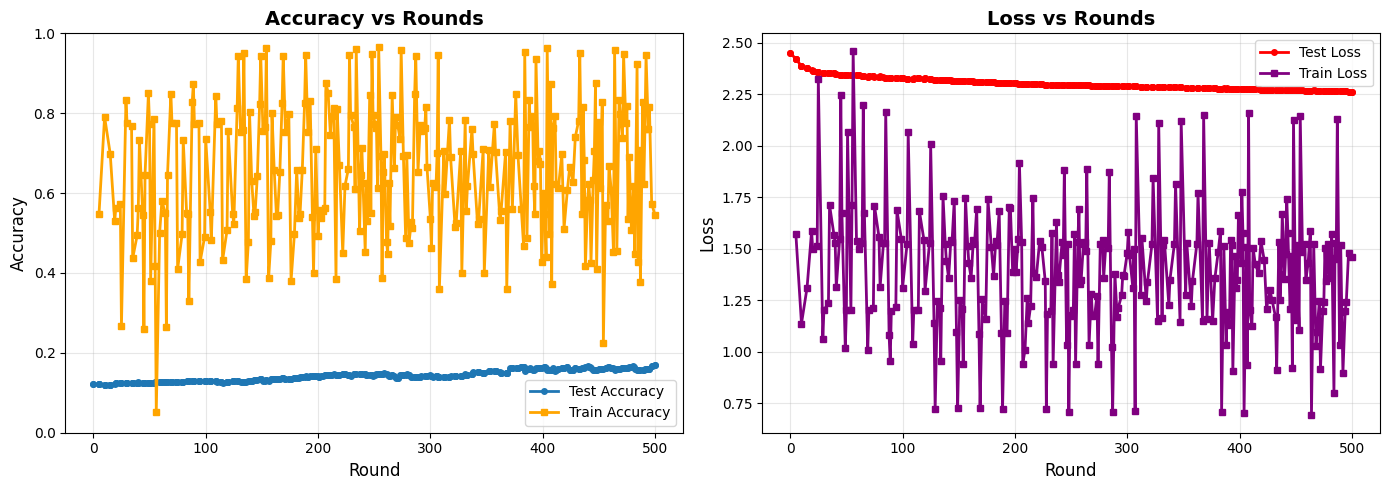

✅ Plot 2 saved: 2_accuracy_loss_vs_time.png


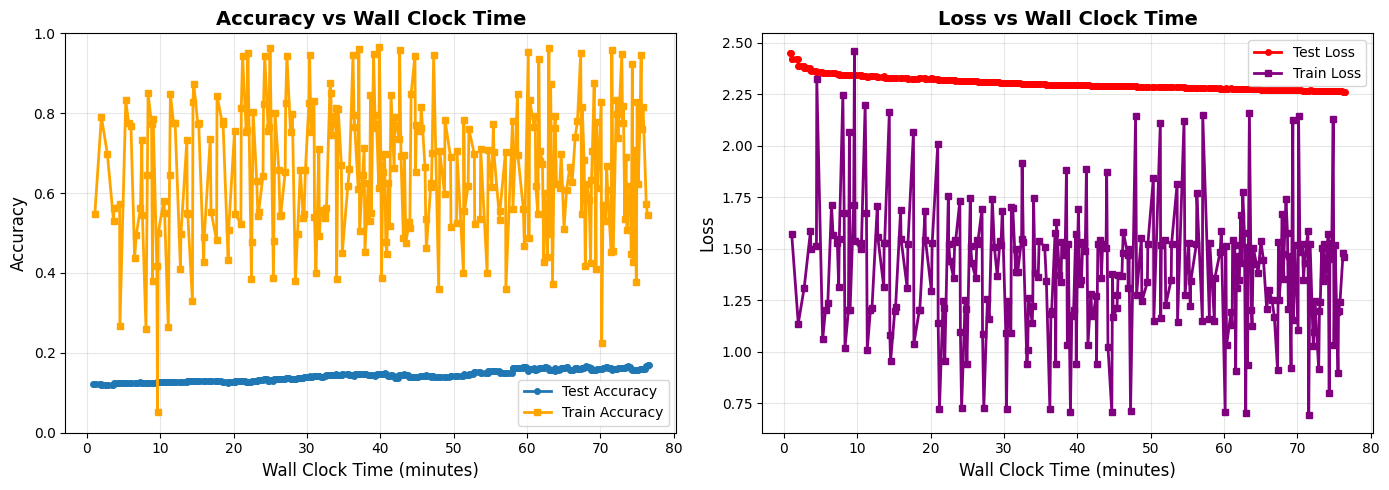

✅ Plot 3 saved: 3_convergence_speed.png


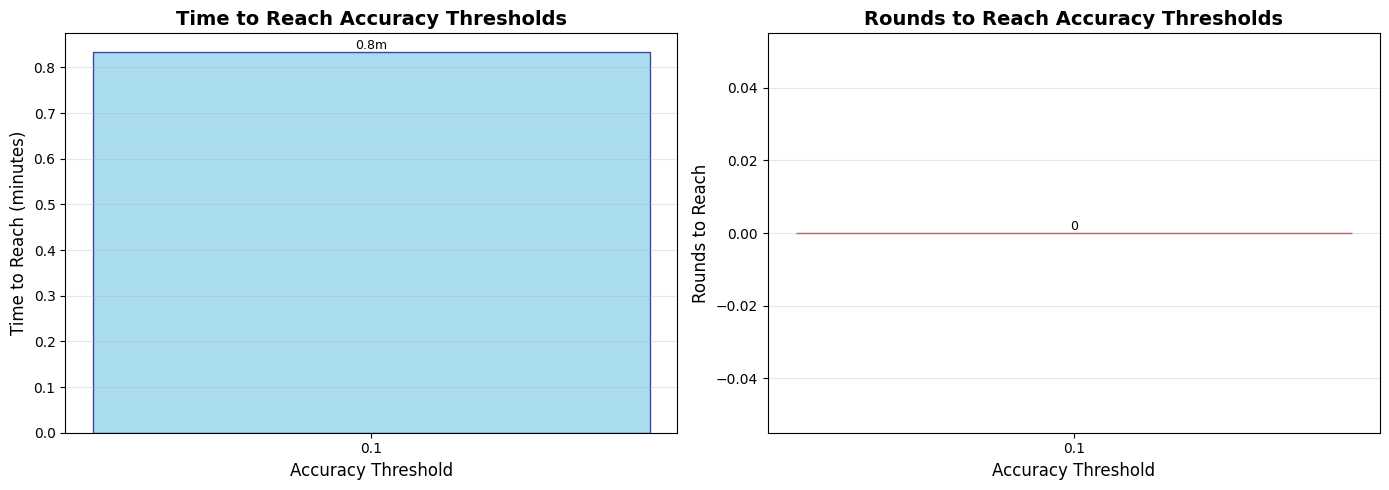

✅ Plot 4 saved: 4_training_efficiency.png


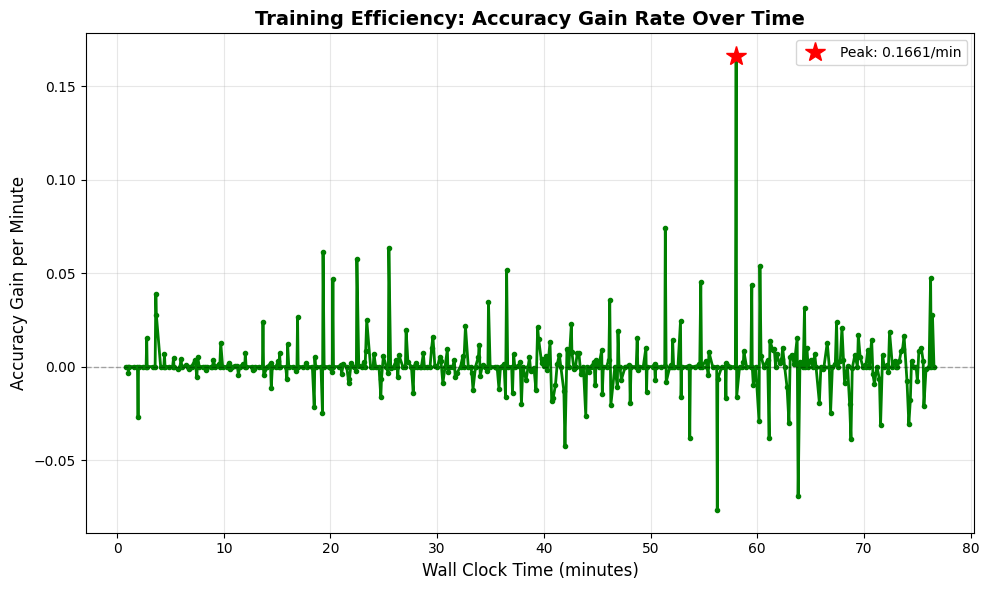

✅ Plot 5 saved: 5_client_participation.png


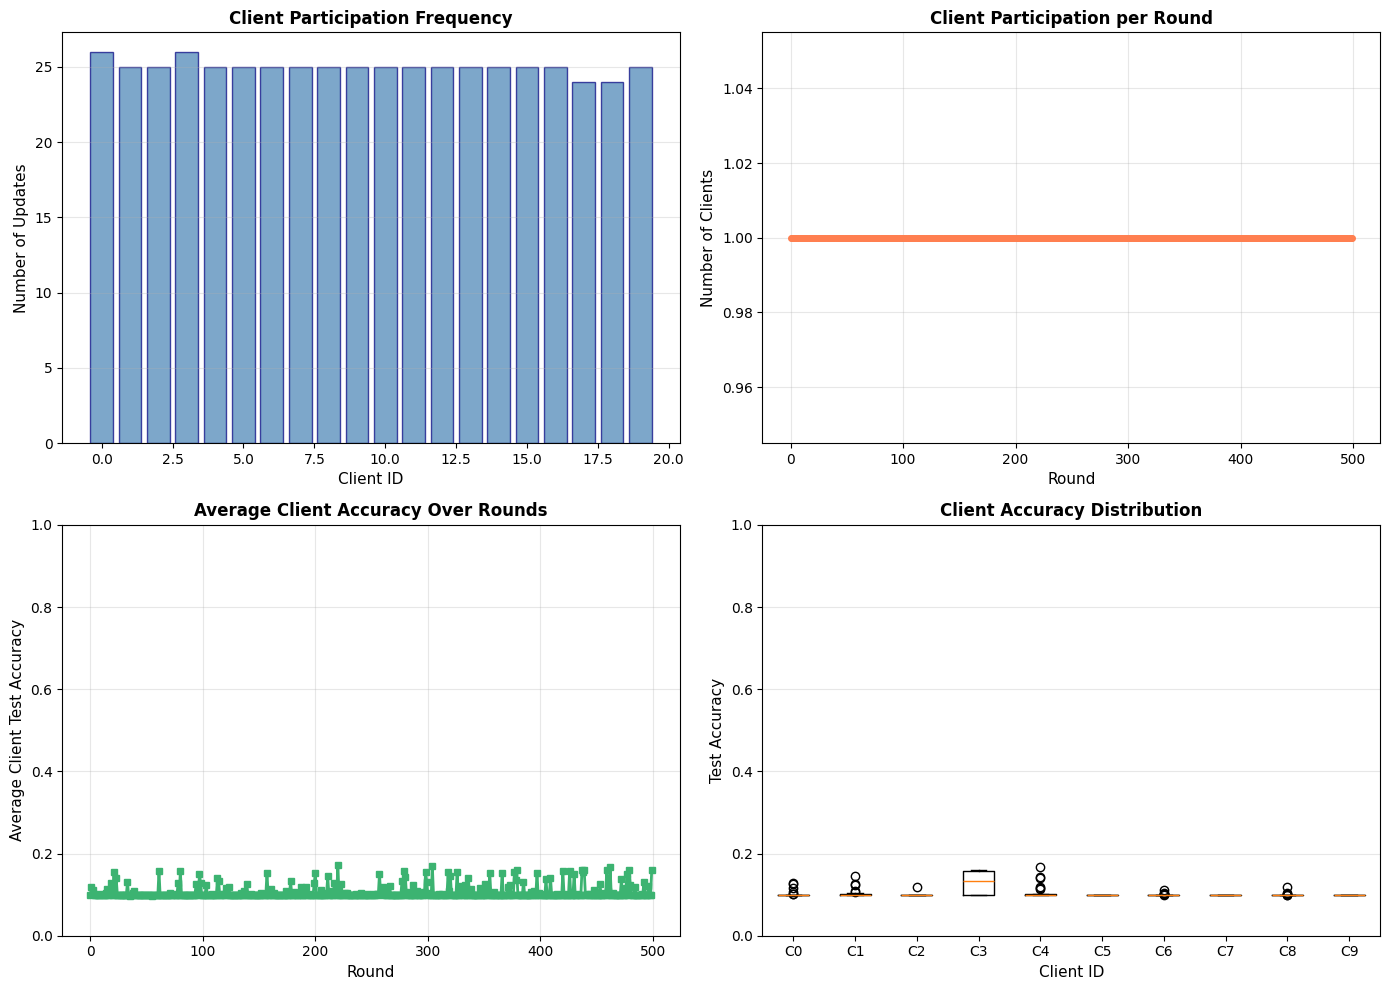

✅ Plot 6 saved: 6_training_summary.png


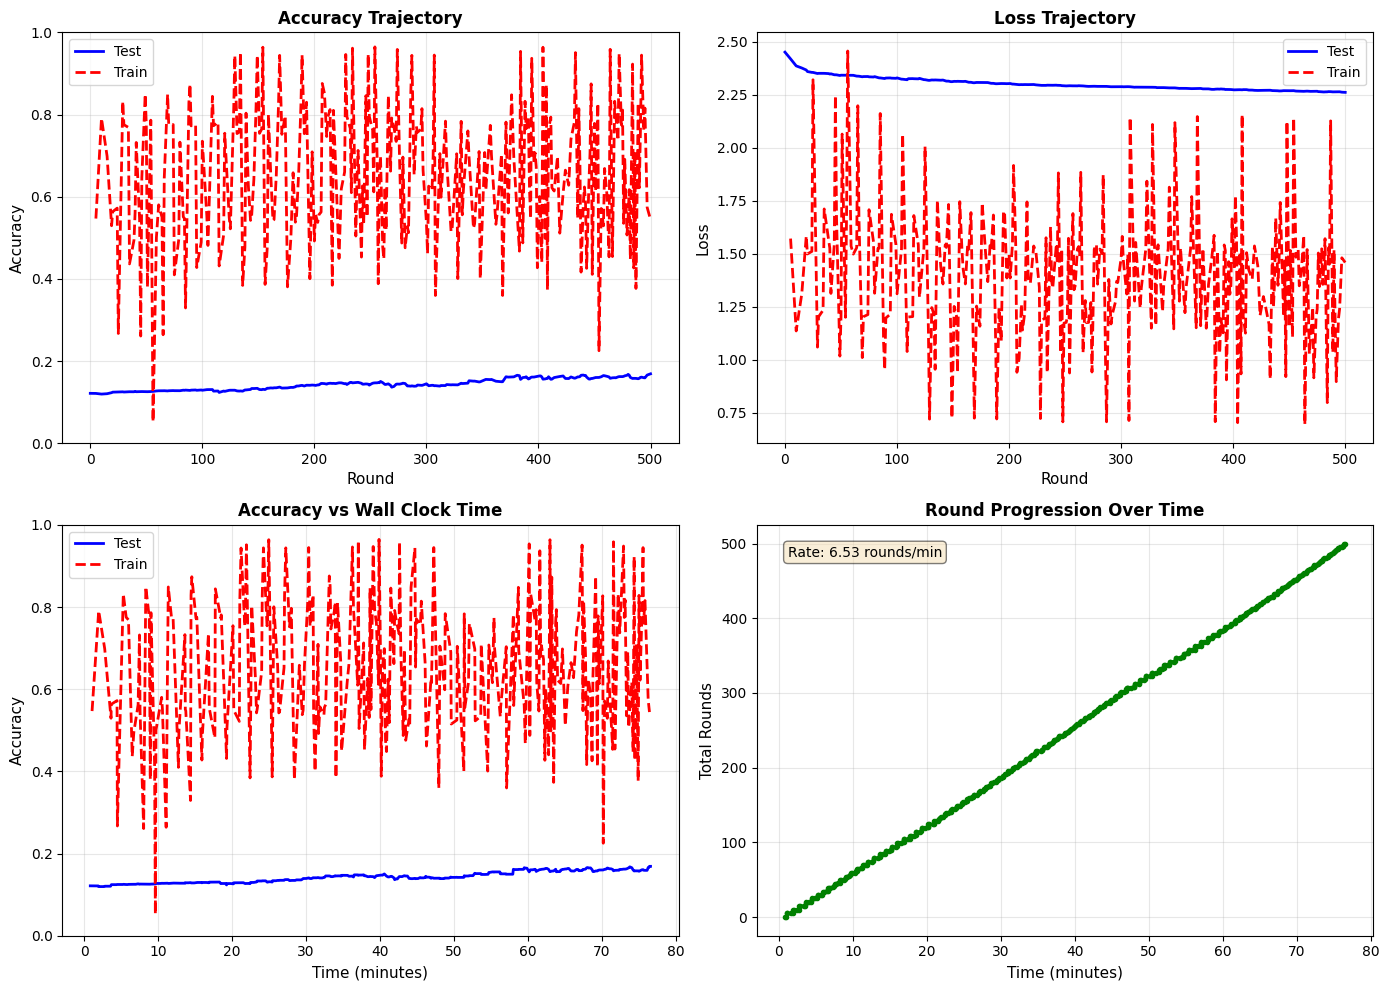


EXPERIMENT SUMMARY STATISTICS
Total Rounds: 500
Total Time: 76.56 minutes (4593.44 seconds)
Final Test Accuracy: 0.1689
Best Test Accuracy: 0.1689 (Round 500)
Average Round Time: 9.19 seconds
Rounds per Minute: 6.53


In [13]:
# Comprehensive visualization suite for a single experiment
# Use this after running experiments - specify the experiment ID and run folder
# Example: run_dir = experiment_results['Exp1']['run_dir']

# For demonstration, we'll use the last completed experiment
if 'experiment_results' in globals() and len(experiment_results) > 0:
    # Get the last completed experiment
    completed_exps = {k: v for k, v in experiment_results.items() if v.get("status") == "completed"}
    if len(completed_exps) > 0:
        # Use the last one
        last_exp_id = list(completed_exps.keys())[-1]
        run_dir = completed_exps[last_exp_id]["run_dir"]
        print(f"📊 Visualizing results for: {last_exp_id}")
        print(f"📁 Run folder: {run_dir}")
    else:
        print("⚠️  No completed experiments found. Run experiments first.")
        run_dir = None
else:
    print("⚠️  No experiment results found. Run experiments first.")
    run_dir = None

if run_dir and Path(run_dir).exists():
    csv_path = Path(run_dir) / "FedAsync.csv"
    participation_path = Path(run_dir) / "FedAsyncClientParticipation.csv"

    if csv_path.exists():
        df = pd.read_csv(csv_path)

        # Convert time to minutes for better readability
        df['time_min'] = df['time'] / 60.0

        # ========== Plot 1: Accuracy vs Rounds ==========
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Test accuracy over rounds
        axes[0].plot(df['total_agg'], df['test_acc'], label='Test Accuracy', marker='o', markersize=4, linewidth=2)
        train_acc = df[df['avg_train_acc'] > 0]['avg_train_acc']
        train_rounds = df[df['avg_train_acc'] > 0]['total_agg']
        if len(train_acc) > 0:
            axes[0].plot(train_rounds, train_acc, label='Train Accuracy', marker='s', markersize=4, linewidth=2, color='orange')
        axes[0].set_xlabel('Round', fontsize=12)
        axes[0].set_ylabel('Accuracy', fontsize=12)
        axes[0].set_title('Accuracy vs Rounds', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(fontsize=10)
        axes[0].set_ylim([0, 1.0])

        # Loss over rounds
        axes[1].plot(df['total_agg'], df['test_loss'], label='Test Loss', marker='o', markersize=4, linewidth=2, color='red')
        train_loss = df[df['avg_train_loss'] > 0]['avg_train_loss']
        train_rounds_loss = df[df['avg_train_loss'] > 0]['total_agg']
        if len(train_loss) > 0:
            axes[1].plot(train_rounds_loss, train_loss, label='Train Loss', marker='s', markersize=4, linewidth=2, color='purple')
        axes[1].set_xlabel('Round', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].set_title('Loss vs Rounds', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(fontsize=10)

        plt.tight_layout()
        plt.savefig(Path(run_dir) / "1_accuracy_loss_vs_rounds.png", dpi=150, bbox_inches='tight')
        print(f"✅ Plot 1 saved: 1_accuracy_loss_vs_rounds.png")
        plt.show()

        # ========== Plot 2: Accuracy vs Wall Clock Time ==========
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Test accuracy over time
        axes[0].plot(df['time_min'], df['test_acc'], label='Test Accuracy', marker='o', markersize=4, linewidth=2)
        train_acc_time = df[df['avg_train_acc'] > 0]['avg_train_acc']
        train_time = df[df['avg_train_acc'] > 0]['time_min']
        if len(train_acc_time) > 0:
            axes[0].plot(train_time, train_acc_time, label='Train Accuracy', marker='s', markersize=4, linewidth=2, color='orange')
        axes[0].set_xlabel('Wall Clock Time (minutes)', fontsize=12)
        axes[0].set_ylabel('Accuracy', fontsize=12)
        axes[0].set_title('Accuracy vs Wall Clock Time', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(fontsize=10)
        axes[0].set_ylim([0, 1.0])

        # Loss over time
        axes[1].plot(df['time_min'], df['test_loss'], label='Test Loss', marker='o', markersize=4, linewidth=2, color='red')
        train_loss_time = df[df['avg_train_loss'] > 0]['avg_train_loss']
        train_time_loss = df[df['avg_train_loss'] > 0]['time_min']
        if len(train_loss_time) > 0:
            axes[1].plot(train_time_loss, train_loss_time, label='Train Loss', marker='s', markersize=4, linewidth=2, color='purple')
        axes[1].set_xlabel('Wall Clock Time (minutes)', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].set_title('Loss vs Wall Clock Time', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(fontsize=10)

        plt.tight_layout()
        plt.savefig(Path(run_dir) / "2_accuracy_loss_vs_time.png", dpi=150, bbox_inches='tight')
        print(f"✅ Plot 2 saved: 2_accuracy_loss_vs_time.png")
        plt.show()

        # ========== Plot 3: Convergence Speed Analysis ==========
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Time to reach accuracy thresholds
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        times_to_threshold = []
        rounds_to_threshold = []
        reached_thresholds = []

        for thresh in thresholds:
            mask = df['test_acc'] >= thresh
            if mask.any():
                first_idx = mask.idxmax()
                times_to_threshold.append(df.loc[first_idx, 'time_min'])
                rounds_to_threshold.append(df.loc[first_idx, 'total_agg'])
                reached_thresholds.append(thresh)
            else:
                break

        if len(reached_thresholds) > 0:
            axes[0].bar(range(len(reached_thresholds)), times_to_threshold, color='skyblue', alpha=0.7, edgecolor='navy')
            axes[0].set_xlabel('Accuracy Threshold', fontsize=12)
            axes[0].set_ylabel('Time to Reach (minutes)', fontsize=12)
            axes[0].set_title('Time to Reach Accuracy Thresholds', fontsize=14, fontweight='bold')
            axes[0].set_xticks(range(len(reached_thresholds)))
            axes[0].set_xticklabels([f'{t:.1f}' for t in reached_thresholds], fontsize=10)
            axes[0].grid(True, alpha=0.3, axis='y')

            # Add value labels on bars
            for i, (t, v) in enumerate(zip(reached_thresholds, times_to_threshold)):
                axes[0].text(i, v, f'{v:.1f}m', ha='center', va='bottom', fontsize=9)

            axes[1].bar(range(len(reached_thresholds)), rounds_to_threshold, color='lightcoral', alpha=0.7, edgecolor='darkred')
            axes[1].set_xlabel('Accuracy Threshold', fontsize=12)
            axes[1].set_ylabel('Rounds to Reach', fontsize=12)
            axes[1].set_title('Rounds to Reach Accuracy Thresholds', fontsize=14, fontweight='bold')
            axes[1].set_xticks(range(len(reached_thresholds)))
            axes[1].set_xticklabels([f'{t:.1f}' for t in reached_thresholds], fontsize=10)
            axes[1].grid(True, alpha=0.3, axis='y')

            # Add value labels on bars
            for i, (t, v) in enumerate(zip(reached_thresholds, rounds_to_threshold)):
                axes[1].text(i, v, f'{int(v)}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(Path(run_dir) / "3_convergence_speed.png", dpi=150, bbox_inches='tight')
        print(f"✅ Plot 3 saved: 3_convergence_speed.png")
        plt.show()

        # ========== Plot 4: Training Efficiency (Accuracy per Time) ==========
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        # Calculate efficiency: accuracy gain per minute
        if len(df) > 1:
            df_sorted = df.sort_values('time_min')
            efficiency = df_sorted['test_acc'].diff() / df_sorted['time_min'].diff()
            efficiency = efficiency.fillna(0)

            ax.plot(df_sorted['time_min'], efficiency, marker='o', markersize=3, linewidth=2, color='green')
            ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
            ax.set_xlabel('Wall Clock Time (minutes)', fontsize=12)
            ax.set_ylabel('Accuracy Gain per Minute', fontsize=12)
            ax.set_title('Training Efficiency: Accuracy Gain Rate Over Time', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)

            # Highlight peak efficiency
            max_eff_idx = efficiency.idxmax()
            max_eff_time = df_sorted.loc[max_eff_idx, 'time_min']
            max_eff_val = efficiency.loc[max_eff_idx]
            ax.plot(max_eff_time, max_eff_val, 'r*', markersize=15, label=f'Peak: {max_eff_val:.4f}/min')
            ax.legend(fontsize=10)

        plt.tight_layout()
        plt.savefig(Path(run_dir) / "4_training_efficiency.png", dpi=150, bbox_inches='tight')
        print(f"✅ Plot 4 saved: 4_training_efficiency.png")
        plt.show()

        # ========== Plot 5: Client Participation Analysis ==========
        if participation_path.exists():
            part_df = pd.read_csv(participation_path)

            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            # Client participation frequency
            client_counts = part_df['client_id'].value_counts().sort_index()
            axes[0, 0].bar(client_counts.index, client_counts.values, color='steelblue', alpha=0.7, edgecolor='navy')
            axes[0, 0].set_xlabel('Client ID', fontsize=11)
            axes[0, 0].set_ylabel('Number of Updates', fontsize=11)
            axes[0, 0].set_title('Client Participation Frequency', fontsize=12, fontweight='bold')
            axes[0, 0].grid(True, alpha=0.3, axis='y')

            # Client participation over rounds
            participation_by_round = part_df.groupby('total_agg')['client_id'].count()
            axes[0, 1].plot(participation_by_round.index, participation_by_round.values,
                           marker='o', markersize=4, linewidth=2, color='coral')
            axes[0, 1].set_xlabel('Round', fontsize=11)
            axes[0, 1].set_ylabel('Number of Clients', fontsize=11)
            axes[0, 1].set_title('Client Participation per Round', fontsize=12, fontweight='bold')
            axes[0, 1].grid(True, alpha=0.3)

            # Average client accuracy over time
            client_acc_by_round = part_df.groupby('total_agg')['local_test_acc'].mean()
            axes[1, 0].plot(client_acc_by_round.index, client_acc_by_round.values,
                            marker='s', markersize=4, linewidth=2, color='mediumseagreen')
            axes[1, 0].set_xlabel('Round', fontsize=11)
            axes[1, 0].set_ylabel('Average Client Test Accuracy', fontsize=11)
            axes[1, 0].set_title('Average Client Accuracy Over Rounds', fontsize=12, fontweight='bold')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].set_ylim([0, 1.0])

            # Client accuracy distribution (box plot)
            if len(part_df) > 0:
                client_accs = [part_df[part_df['client_id'] == cid]['local_test_acc'].values
                              for cid in sorted(part_df['client_id'].unique())[:10]]  # Limit to first 10 clients
                if len(client_accs) > 0:
                    axes[1, 1].boxplot(client_accs, labels=[f'C{i}' for i in range(len(client_accs))])
                    axes[1, 1].set_xlabel('Client ID', fontsize=11)
                    axes[1, 1].set_ylabel('Test Accuracy', fontsize=11)
                    axes[1, 1].set_title('Client Accuracy Distribution', fontsize=12, fontweight='bold')
                    axes[1, 1].grid(True, alpha=0.3, axis='y')
                    axes[1, 1].set_ylim([0, 1.0])

            plt.tight_layout()
            plt.savefig(Path(run_dir) / "5_client_participation.png", dpi=150, bbox_inches='tight')
            print(f"✅ Plot 5 saved: 5_client_participation.png")
            plt.show()

        # ========== Plot 6: Training Progress Summary ==========
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Accuracy trajectory
        axes[0, 0].plot(df['total_agg'], df['test_acc'], 'b-', linewidth=2, label='Test')
        train_acc_plot = df[df['avg_train_acc'] > 0]
        if len(train_acc_plot) > 0:
            axes[0, 0].plot(train_acc_plot['total_agg'], train_acc_plot['avg_train_acc'],
                           'r--', linewidth=2, label='Train')
        axes[0, 0].set_xlabel('Round', fontsize=11)
        axes[0, 0].set_ylabel('Accuracy', fontsize=11)
        axes[0, 0].set_title('Accuracy Trajectory', fontsize=12, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim([0, 1.0])

        # Loss trajectory
        axes[0, 1].plot(df['total_agg'], df['test_loss'], 'b-', linewidth=2, label='Test')
        train_loss_plot = df[df['avg_train_loss'] > 0]
        if len(train_loss_plot) > 0:
            axes[0, 1].plot(train_loss_plot['total_agg'], train_loss_plot['avg_train_loss'],
                           'r--', linewidth=2, label='Train')
        axes[0, 1].set_xlabel('Round', fontsize=11)
        axes[0, 1].set_ylabel('Loss', fontsize=11)
        axes[0, 1].set_title('Loss Trajectory', fontsize=12, fontweight='bold')
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)

        # Accuracy vs time
        axes[1, 0].plot(df['time_min'], df['test_acc'], 'b-', linewidth=2, label='Test')
        if len(train_acc_plot) > 0:
            train_time_acc = df[df['avg_train_acc'] > 0]['time_min']
            axes[1, 0].plot(train_time_acc, train_acc_plot['avg_train_acc'],
                            'r--', linewidth=2, label='Train')
        axes[1, 0].set_xlabel('Time (minutes)', fontsize=11)
        axes[1, 0].set_ylabel('Accuracy', fontsize=11)
        axes[1, 0].set_title('Accuracy vs Wall Clock Time', fontsize=12, fontweight='bold')
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_ylim([0, 1.0])

        # Round progression over time
        axes[1, 1].plot(df['time_min'], df['total_agg'], 'g-', linewidth=2, marker='o', markersize=3)
        axes[1, 1].set_xlabel('Time (minutes)', fontsize=11)
        axes[1, 1].set_ylabel('Total Rounds', fontsize=11)
        axes[1, 1].set_title('Round Progression Over Time', fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

        # Add rate annotation
        if len(df) > 1:
            total_time = df['time_min'].iloc[-1]
            total_rounds = df['total_agg'].iloc[-1]
            rate = total_rounds / total_time if total_time > 0 else 0
            axes[1, 1].text(0.05, 0.95, f'Rate: {rate:.2f} rounds/min',
                           transform=axes[1, 1].transAxes, fontsize=10,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.savefig(Path(run_dir) / "6_training_summary.png", dpi=150, bbox_inches='tight')
        print(f"✅ Plot 6 saved: 6_training_summary.png")
        plt.show()

        # ========== Print Summary Statistics ==========
        print("\n" + "="*60)
        print("EXPERIMENT SUMMARY STATISTICS")
        print("="*60)
        print(f"Total Rounds: {df['total_agg'].max()}")
        print(f"Total Time: {df['time_min'].iloc[-1]:.2f} minutes ({df['time'].iloc[-1]:.2f} seconds)")
        print(f"Final Test Accuracy: {df['test_acc'].iloc[-1]:.4f}")
        print(f"Best Test Accuracy: {df['test_acc'].max():.4f} (Round {df.loc[df['test_acc'].idxmax(), 'total_agg']})")
        if len(df) > 1:
            print(f"Average Round Time: {(df['time'].iloc[-1] / df['total_agg'].iloc[-1]):.2f} seconds")
            print(f"Rounds per Minute: {(df['total_agg'].iloc[-1] / df['time_min'].iloc[-1]):.2f}")
        print("="*60)

    else:
        print("Results file not found yet.")
else:
    print("⚠️  No experiment results found. Run experiments first using Section 8.")
